# Machine Learning Megaline

La compañía Megaline me pide desarrollar un modelo de prueba que analice el comportamiento de los clientes para luego recomendarles uno de los siguientes planes: Smart o Ultra 

Dentro del DataFrame vamos a encontrar los siguientes datos:
- `сalls` — número de llamadas,
- `minutes` — duración total de la llamada en minutos,
- `messages` — número de mensajes de texto,
- `mb_used` — Tráfico de Internet utilizado en MB,
- `is_ultra` — plan para el mes actual (Ultra - 1, Smart - 0).

Importar las librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer
from scipy.stats import randint as sp_randint
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Cargar datos

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

## Exploración de los datos

Vamos a ver como se encuentran los datos del DataFrame

In [3]:
df

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


Quiero ver el Dtype de los datos para corroborar que se encuentren correctos

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Se ven correctos menos `is_ultra` deberia ser del tipo booleano, voy a corregirlo

In [5]:
df['is_ultra'] = df['is_ultra'].astype('bool')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   bool   
dtypes: bool(1), float64(4)
memory usage: 103.7 KB


Quedo todo bien ahora

Buscamos si hay datos ausentes en el DataFrame

In [6]:
df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

No se encontraron datos ausentes que afecten el analisís

## Visualización de los datos

### Feature

Visualicemos los datos un poco mejor, comencemos haciendo un histograma de las variables que voy a definir como `Feature`('calls', 'minutes', 'messages', 'mb_used')

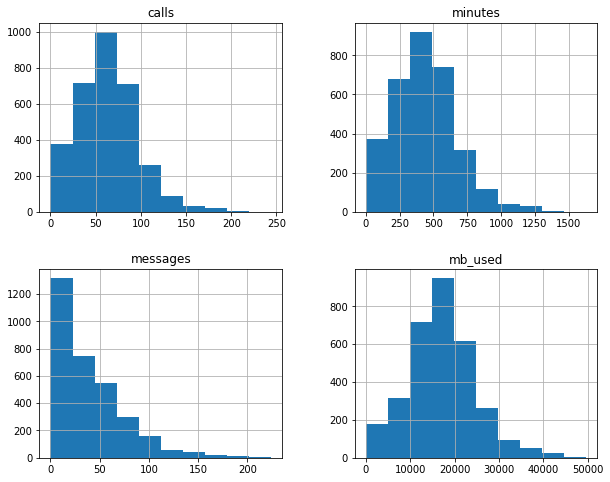

In [7]:
df.hist(column=['calls', 'minutes', 'messages', 'mb_used'], figsize=(10,8))
plt.show()

De estos histogramas podemos ver las siguientes cosas:
- La mayoria de los usuarios realizan 60 llamadas al mes aproximadamente
- La media de los minutos utilizados al mes es de 300 a 500
- Casi no se usan los mensajes de textos
- Los datos usados tiene un promedio de entre 1500 a 2000 mb al mes

### Target

Ahora veamos como se comporta la variable `Target`('is_ultra')

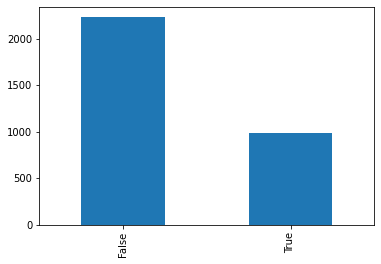

In [8]:
df['is_ultra'].value_counts().plot(kind='bar')
plt.show()

En este grafico vemos que 2/3 de los ususarios tienen el plan `Smart`(False) y 1/3 el plan `Ultra`(True)

### Relación entre las variables

Ahora grafico la relación entre `Feature` y `Target`

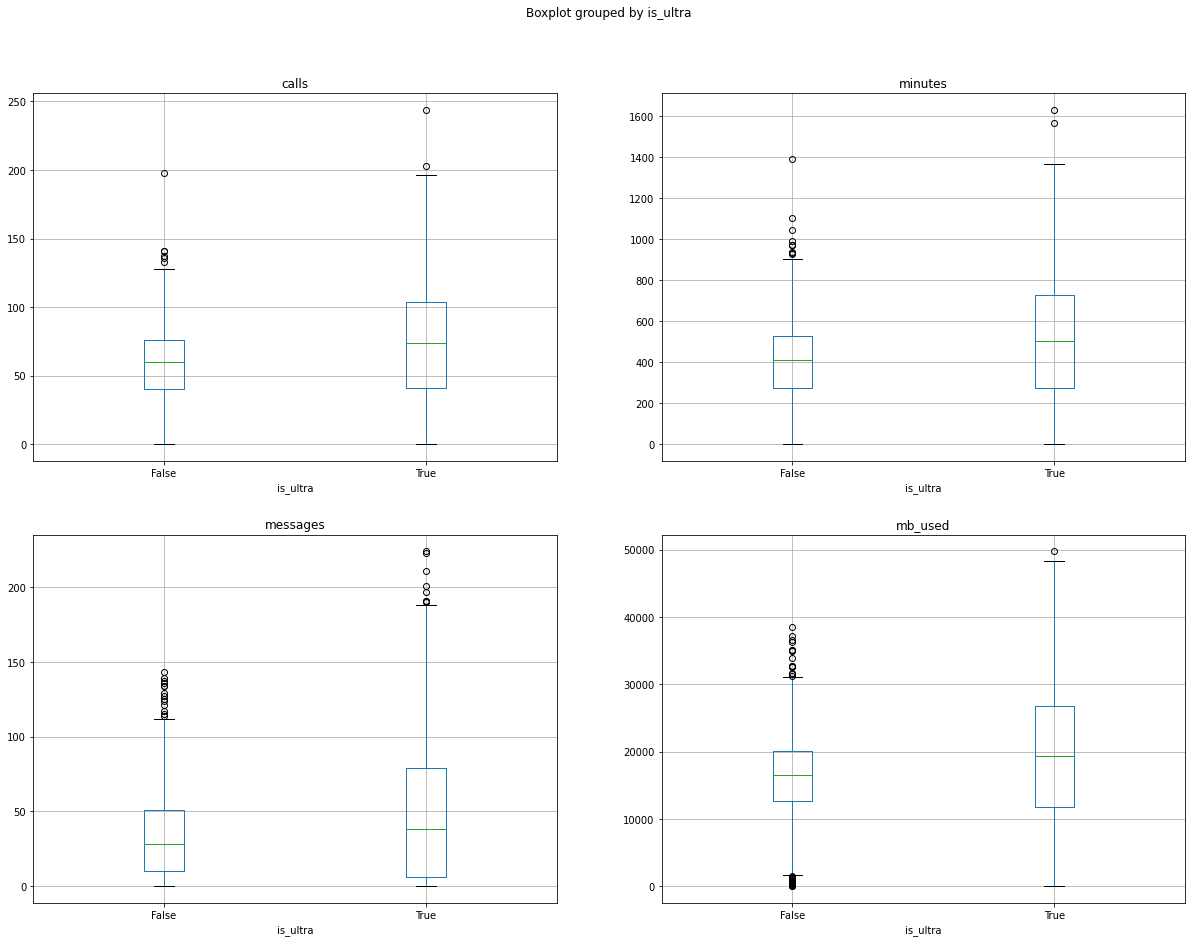

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(20, 15))

df.boxplot(column='calls', by='is_ultra', ax=axs[0, 0])
df.boxplot(column='minutes', by='is_ultra', ax=axs[0, 1])
df.boxplot(column='messages', by='is_ultra', ax=axs[1, 0])
df.boxplot(column='mb_used', by='is_ultra', ax=axs[1, 1])

plt.show()

Conclusiones de los boxplot:
- Los usuarios de Ultra realizan mas llamadas que los de Smart.
- Los minutos usuados para las llamadas son mayores en los usuarios de Ultra.
- Los mensajes de texto enviados son casi el doble en Ultra que en Smart.
- La mayoria de datos usados corresponden al plan Ultra.

## Segmentación de los datos

Ahora voy a segmentar el DataFrame para entrenar a los modelos, la segmentación va a ser:
- 60% datos para el entrenamiento
- 20% datos de validación
- 20% datos de prueba

In [10]:
# Se separan los datos en dos conjuntos: uno de entrenamiento y otro de prueba
train_df, test_df = train_test_split(df, test_size=0.2, random_state=12345)

# Se separa el conjunto de entrenamiento en dos conjuntos: uno de entrenamiento y otro de validación
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=12345)

# Se imprimen las dimensiones de los conjuntos resultantes
print(f"Datos de entrenamiento: {train_df.shape}")
print(f"Datos de validación: {val_df.shape}")
print(f"Datos de prueba: {test_df.shape}")

Datos de entrenamiento: (1928, 5)
Datos de validación: (643, 5)
Datos de prueba: (643, 5)


La segmentación fue correcta, ya que  los 1928 datos representan el 60% y los 643 el 20% de los datos para la validación y la prueba.

## Calidad de diferentes modelos

Creare 3 modelos de aprendizaje diferentes para ver cual es el que tiene una mejor presición. Los modelos van a ser:
- Árbol de Decisión
- Bosque de Aleatorio
- Regresión Logistica

En cada uno de los casos voy a imprimir la precisión (acurracy) y los mejores hiperparametros para cada modelo

### Árbol de decisión

In [11]:
# Defino el modelo a utilizar
model = DecisionTreeClassifier(random_state=12345)

# Ajusto el modelo con los datos de entrenamiento
model.fit(train_df.drop("is_ultra", axis=1), train_df["is_ultra"])

# Se realiza una predicción sobre los datos de prueba
y_pred = model.predict(test_df.drop("is_ultra", axis=1))

# Se evalúa el desempeño del modelo utilizando la precisión
accuracy = accuracy_score(test_df["is_ultra"], y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Definicion de la grilla de hiperparámetros a explorar
params = {
    "max_depth": randint(1, 20),
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["sqrt", "log2", None]
}

# Se realiza la búsqueda aleatoria de hiperparámetros
search = RandomizedSearchCV(model, params, n_iter=100, cv=5, random_state=12345)
search.fit(train_df.drop("is_ultra", axis=1), train_df["is_ultra"])

# Se imprime el mejor conjunto de hiperparámetros encontrado
print(search.best_params_)

Accuracy: 0.7309
{'max_depth': 5, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 8}


### Bosque aleatorio

In [12]:
# Definicion del modelo a utilizar
model = RandomForestClassifier()

# Definicion de los hiperparámetros a ajustar y los rangos de búsqueda
param_dist = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": sp_randint(2, 11),
    "min_samples_leaf": sp_randint(1, 11),
}

# Se define la métrica de desempeño a utilizar
scorer = make_scorer(accuracy_score)

# Se realiza la búsqueda de hiperparámetros utilizando validación cruzada
search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring=scorer,
    random_state=12345,
)

# Se ajusta el modelo con los mejores hiperparámetros encontrados
search.fit(train_df.drop("is_ultra", axis=1), train_df["is_ultra"])

# Se evalúa el modelo en el conjunto de prueba y cuales son los mejores parametros
y_pred = search.predict(test_df.drop("is_ultra", axis=1))
accuracy = accuracy_score(test_df["is_ultra"], y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(search.best_params_)

Accuracy: 0.7947
{'max_depth': 10, 'min_samples_leaf': 9, 'min_samples_split': 2, 'n_estimators': 300}


### Regresión Logistica

In [13]:
# Aplico filtro para no ver los warnings
warnings.filterwarnings('ignore')

# Se separa el conjunto de datos en entrenamiento y prueba
feature_train, feature_test, target_train, target_test = train_test_split(df.drop("is_ultra", axis=1), df["is_ultra"], test_size=0.2, random_state=12345)
# Definicion del modelo a utilizar
model = LogisticRegression(random_state=12345)

# Definicion de la grilla de hiperparámetros a explorar
params = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Se realiza la búsqueda por cuadrícula de hiperparámetros
search = GridSearchCV(model, params, cv=5, scoring='accuracy')
search.fit(feature_train, target_train)

# Se imprime el mejor conjunto de hiperparámetros encontrado
print(search.best_params_)

# Se hace la predicción sobre el conjunto de prueba
target_pred = search.predict(feature_test)

# Se calcula la precisión del modelo
accuracy = accuracy_score(target_test, target_pred)

# Se imprime la precisión del modelo
print(f"Accuracy: {accuracy:.4f}")



{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.7605


### Conclusiónes

El mejor modelo para tomar deciciones es el del `bosque de decisión` ya que este tiene una presición del 79,78%, mientras que le sigue la `regresión logistica` con el 76,05% y por ultimo el `árbol de decisión` con el 73,09%

## Comprobación de la calidad del modelo

Voy a probar el modelo del bosque de decisión con los datos que separe para la prueba y ver como se comporta, si me da un valor parecido de la precisión del entrenamiento o no. Para ello voy a usar los hiperparametros que mejor se adecuan y que ya averigüe cuales son:
- `max_depth`: 10
- `min_samples_leaf`: 8
- `min_samples_split`: 9
- `n_estimators`: 300


In [14]:
# Definimos el modelo con los parámetros encontrados
model = RandomForestClassifier(
    max_depth=5,
    max_features=None,
    min_samples_leaf=9,
    min_samples_split=8,
    random_state=12345
)

# Ajustamos el modelo con los datos de prueba
model.fit(feature_test, target_test)

# Se ajusta el modelo con los mejores hiperparámetros encontrados
search.fit(test_df.drop("is_ultra", axis=1), test_df["is_ultra"])

# Se evalúa el modelo en el conjunto de prueba y cuales son los mejores parametros
y_pred = search.predict(test_df.drop("is_ultra", axis=1))
accuracy = accuracy_score(test_df["is_ultra"], y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7512


 La presición del modelo de prueba es del 75,12% es menor que la del modelo de entrenamiento que fue de 79,78%, pero es un nivel aceptable

## Prueba de cordura

### Dummy

In [21]:
# Definición del modelo Dummy
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(train_df.drop("is_ultra", axis=1), train_df["is_ultra"])
dummy_preds = dummy.predict(test_df.drop("is_ultra", axis=1))

# Evaluación del modelo Dummy
print("Resultados del modelo Dummy")
print(classification_report(test_df["is_ultra"], dummy_preds))

# Definición del modelo Random Forest con los mejores parámetros encontrados
model = RandomForestClassifier(
    max_depth=5, max_features=None, min_samples_leaf=9, min_samples_split=8
)

# Entrenamiento del modelo
model.fit(train_df.drop("is_ultra", axis=1), train_df["is_ultra"])

# Predicción sobre el conjunto de prueba
y_pred = model.predict(test_df.drop("is_ultra", axis=1))

# Evaluación del modelo
print("Resultados del modelo Bosque de Decisión")
print(classification_report(test_df["is_ultra"], y_pred))

Resultados del modelo Dummy
              precision    recall  f1-score   support

       False       0.70      1.00      0.82       447
        True       0.00      0.00      0.00       196

    accuracy                           0.70       643
   macro avg       0.35      0.50      0.41       643
weighted avg       0.48      0.70      0.57       643

Resultados del modelo Bosque de Decisión
              precision    recall  f1-score   support

       False       0.80      0.94      0.86       447
        True       0.76      0.46      0.58       196

    accuracy                           0.79       643
   macro avg       0.78      0.70      0.72       643
weighted avg       0.79      0.79      0.77       643



Podemos observar que la precisión del Dummy es del 70%, mientras que la de nuestro Bosque de Decisión es de 79%

### Matrix de Confusión

In [20]:
print(confusion_matrix(test_df["is_ultra"], dummy_preds))
print(confusion_matrix(test_df["is_ultra"], y_pred))

[[447   0]
 [196   0]]
[[417  30]
 [105  91]]


Cuando realizamos una matrix de confusión de los 2 modelos observamos que el modelo `Dummy` presenta 447 Verdaderos Positivos y 0 Falsos Positivos, por otro lado tambien hay 196 Falso Negativos y 0 Verdaderos Negativos, que no se vean verdaderos nagetivos es raro.

Por el contrario nuestro modelo de `Bosque de Decisión` es mas acorde a un caso verdadero.

## Conclusión

Del trabajo realizado se llego a las siguientes conclusiones:
- De los 3 modelos que se realizaron el mejor de todos fue el `bosque de decisión` si bien es mas lento que los otros 2 su precisón fue casi un 4% mejor que la `regresión logistica` y un 7% que el `árbol de decisión`, si bien no parace mucho son 135 personas menos a las que se le recomendo un plan adecuado para ellas que puede llegar a representar perdidas para la compañia si es que se les asigno el plan mas bajo cuando debia ser el mas alto y este 7% es solo sobre 1928 personas, si en número fuera mayor también lo seria ese 7%.

- Cuando se aplico los datos de prueba la precisión fue del 75%, un poco menor que en el entrenamiento (79%), pero se encuentra dentro del umbral requerido.

- En la prueba de cordura, el modelo Dummy tuvo una presición menor que la de nuestro modelo, lo que indica que nuestro modelo elegido funciona mejor a la hora de analizar los comportamientos de los clientes y  recomendar los planes adecuados para ellos.